In [213]:
import os
os.chdir('../quafing/')
print(os.getcwd())


import quafing as q
import numpy as np
import pickle
import random
import math


import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15, 
                     "figure.dpi" : 100, 
                     "legend.fontsize" : 13, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": True, 
                     "axes.axisbelow" : True, 
                     "figure.figsize":(8,6)})


from sklearn.metrics import euclidean_distances
from sklearn.preprocessing import LabelEncoder


import pandas as pd
pd.options.mode.chained_assignment = None

/Users/charlesdupont/Desktop/Thesis/code/quafing


In [177]:
DATA_DIR    = "../../BCCASII/"
DATA_SUBDIR = "Household/"

In [532]:
def load_data(path):
    """
    Loads .dta file using provided path.
    """
    return pd.read_stata(path, convert_categoricals=False)


def chunks(l, n):
    L = len(l)
    num_groups = math.floor(L/n)
    end_chunk = l[int(num_groups*n):]
    l = l[:int(num_groups*n)]
    
    groups = []
    for i in range(0, len(l), n):
        groups.append(l[i:i + n])
    
    for i, item in enumerate(end_chunk):
        groups[i].append(item)
    
    return groups


def FINE(rawdata, variable_types, replace_missing=False, d=2, random_grouping=False):  
    
    # check in case of systemic non-response for specific communities
    grouped = rawdata.groupby("community_code")
    missing_prop = {}

    for col in rawdata.columns:
        unique = grouped[col].unique()
        count = 0
        communities = set()
        idx = unique.index
        for i, item in enumerate(unique):
            if len(item) == 1 and item[0] == -1:
                print(col)
                break
                
    if random_grouping:
        rawdata = rawdata.drop(["community_code"], axis=1)
        rawdata = rawdata.reset_index(drop=True)
        idx = list(rawdata.index)
        random.shuffle(idx)
        random_groups = list(chunks(idx, 20))

        group_label = {}
        for i,g in enumerate(random_groups):
            for item in g:
                group_label[item]=i

        random_group_col = []
        rawdata = rawdata.reset_index(drop=True)
        for index, _ in rawdata.iterrows():
            random_group_col.append(group_label[index])
            
        rawdata["group_col"] = random_group_col
        group_col = "group_col"

    else:
        group_col = "community_code"
                
    # assign column types and grouping column(s)
    col_types = []
    for col in rawdata.columns:
        if col == group_col:
            col_types.append("g")
        elif variable_types[col] == "binary":
            col_types.append("b")
        elif variable_types[col] == "discrete_categorical":
            col_types.append("u")
        elif variable_types[col] in ["continuous", "discrete_ordered"]:
            col_types.append("o")


    rawmetadata = {
        "ColNames": np.array(rawdata.columns),
        "ColTypes": np.array(col_types),
        "QuestionNumbers": np.array([i for i in range(1, len(rawdata.columns)+1)])
    }
    

    if replace_missing:
        # replace missing values with uniformly selected choice from options
        for c in rawdata.columns:
            options = [x for x in rawdata[c].unique() if x!=-1]
            vals = list(rawdata[c])
            for i, v in enumerate(vals):
                if v == -1:
                    vals[i] = np.random.choice(options)
            rawdata[c] = vals
            
    prep = q.PreProcessor(rawdata, rawmetadata)
    prep.select_columns(select_all=True)
    prep.set_cont_disc()
    prep.set_density_method(method='Discrete1D', cols=['o','u','b'])
    prep.split_to_groups(group_col)
    
    mdpdfcol = q.create_mdpdf_collection('factorized', prep._groups, prep._grouplabels, prep._groupcolmetadata,)
    mdpdfcol.calculate_distance_matrix(method='hellinger', pwdist='rms')
    mdpdfcol.calculate_shortest_path_matrix()
    
    embedder = q.get_embedder('mds', mdpdfcol)
    embedding = embedder.embed(dimension=d, return_all=True)
    q.plot_embedding(embedding, mdpdfcol)
    
    return embedding["embedding"]

# 1) Handpicked features, group by community code

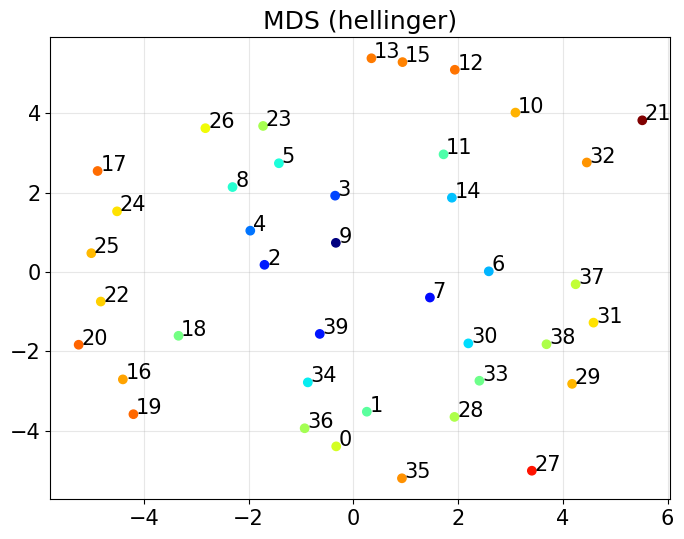

In [523]:
filepath                = DATA_DIR + DATA_SUBDIR + "top_features.xlsx"
variable_types_filepath = DATA_DIR + DATA_SUBDIR + "top_variable_types.pickle"

# load data file and variable types
rawdata = pd.read_excel(filepath)
with open(variable_types_filepath, "rb") as f:
    variable_types = pickle.load(f)

_ = FINE(rawdata, variable_types)

# 2) Handpicked features, group randomly

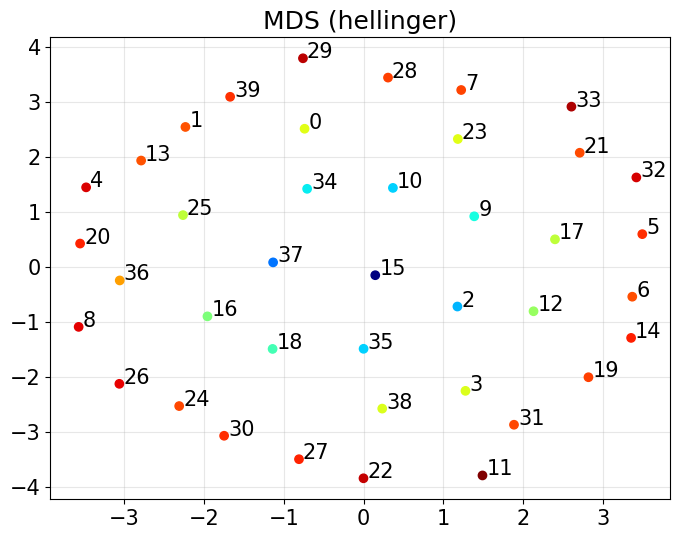

In [524]:
filepath                = DATA_DIR + DATA_SUBDIR + "top_features.xlsx"
variable_types_filepath = DATA_DIR + DATA_SUBDIR + "top_variable_types.pickle"

# load data file and variable types
rawdata = pd.read_excel(filepath)
with open(variable_types_filepath, "rb") as f:
    variable_types = pickle.load(f)

_ = FINE(rawdata, variable_types, random_grouping=True)

# 3) Spatial information

In [533]:
filename = "001_mod_a.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [534]:
df[["hhid", "ucode", "tcode", "dcode", "ezcode"]].describe()

,hhid,ucode,tcode,dcode,ezcode
count,827.000000,827.000000,827.000000,827.000000,827.000000
mean,397.152740,20.307134,19.665054,16.141475,4.119710
std,231.223755,11.547878,11.154550,9.276128,1.959378
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,193.500000,10.000000,10.000000,7.000000,3.000000
50%,393.000000,20.000000,19.000000,16.000000,4.000000
75%,597.500000,30.000000,29.000000,24.000000,6.000000
max,800.000000,40.000000,39.000000,31.000000,7.000000


In [535]:
rawdata = df[["hhid", "dcode", "ezcode"]]

# construct community code from union, thana, district codes
rawdata["community_code"] = df["ucode"].astype(str) + "_" + \
                            df["tcode"].astype(str) + "_" + \
                            df["dcode"].astype(str)
rawdata["community_code"] = LabelEncoder().fit_transform(rawdata["community_code"])

variable_types = {
    "ucode": "discrete_categorical",
    "tcode": "discrete_categorical",
    "dcode": "discrete_categorical",
    "ezcode": "discrete_categorical"
}

In [536]:
# construct map from hhid to community code
HHID_COMMUNITY = {}
for index, row in rawdata.iterrows():
    HHID_COMMUNITY[row["hhid"]] = int(row["community_code"])

In [537]:
rawdata = rawdata[["dcode", "ezcode", "community_code"]]

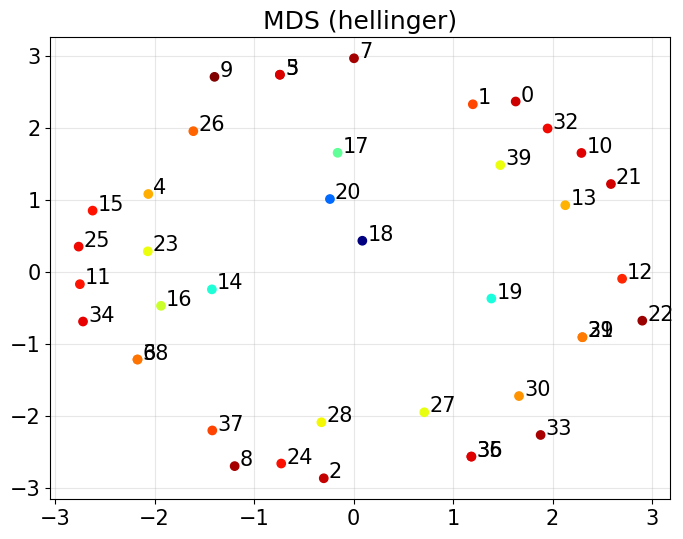

In [538]:
emb_spatial = FINE(rawdata, variable_types)

# 4) Adaptation options

In [579]:
filename = "019_mod_o.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

keep = ["hhid", "o01"] + [f"o0{i}_1" for i in range(2, 9)] + ["o09"] + [f"o{i}" for i in range(10, 23)]
df = df[keep]
keep.remove("hhid")
df[keep] = df[keep].replace(2, 0)
df = df.fillna(-1)

In [580]:
filename = "020_mod_o1.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df2 = load_data(path)

keep = ["hhid"] + ["o1_01_"+str(i) for i in range(1, 10)]
df2 = df2[keep]
keep.remove("hhid")
df2[keep] = df2[keep].replace(2, 0)
df2 = df2.fillna(-1)

In [581]:
df = df.merge(df2, on="hhid")

In [582]:
# insert community codes
community_codes = {"hhid":[], "community_code":[]}
for index, row in df.iterrows():
    hhid = row["hhid"]
    community_codes["hhid"].append(hhid)
    community_codes["community_code"].append(HHID_COMMUNITY[hhid])
    
community_codes = pd.DataFrame.from_dict(community_codes)

df = df.merge(community_codes, on="hhid")
df = df.drop(["hhid"], axis=1)

In [583]:
# define variable types
variable_types = {}
for col in df.columns:
    if col != "community_code":
        variable_types[col] = "binary"

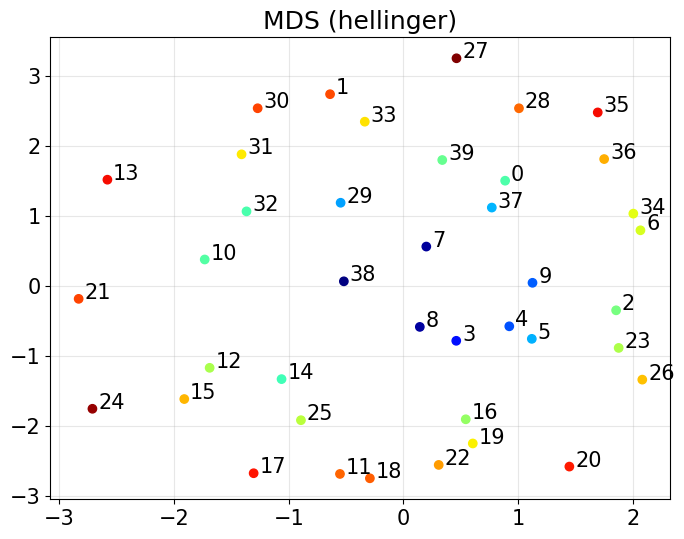

In [584]:
emb_adaptation = FINE(df, variable_types)

# 5) Climatic shocks

In [954]:
filename = "012_mod_l.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

df[["l02"]] = df[["l02"]].replace(2, 0)
df = df[["hhid", "l01", "l02"]]

In [955]:
event_codes = {
    1: "floods",
    2: "flashfloods",
    3: "drought",
    4: "salinity_icnrease",
    5: "sea_level_rise",
    6: "frequent_rainfall",
    7: "temperature_rising",
    8: "temperature_variability",
    9: "soil_river_erosion",
    10: "tornado",
    11: "cyclone",
    12: "seasons_changing",
    13: "unknown_1",
    14: "unknown_2",
    15: "unknown_3"
}

In [956]:
events = {}
for c in event_codes:
    events[event_codes[c]] = {hhid:0 for hhid in df["hhid"].unique()}

for index, row in df.iterrows():
    hhid = row["hhid"]
    code = row["l01"]
    event = event_codes[code]
    events[event][hhid] = 1
    
    
events_df = {"hhid":[]}

for hhid in events["floods"]:
    events_df["hhid"].append(hhid)
    for e in events:
        if e not in events_df:
            events_df[e] = []
        events_df[e].append(events[e][hhid])

events_df = pd.DataFrame.from_dict(events_df)

community_codes = []
for index, row in events_df.iterrows():
    hhid = row["hhid"]
    community_codes.append(HHID_COMMUNITY[hhid])
    
events_df["community_code"] = community_codes

___

In [957]:
filename = "014_mod_l2.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [958]:
shock_codes = {i:f"shock_{i}" for i in range(1,35)}

In [959]:
shocks = {}
for c in shock_codes:
    shocks[shock_codes[c]] = {hhid:0 for hhid in df["hhid"].unique()}

for index, row in df.iterrows():
    hhid = row["hhid"]
    code = int(row["l2_01"])
    if code not in shock_codes:
        continue
    event = shock_codes[code]
    shocks[event][hhid] = 1
    
shocks_df = {"hhid":[]}
for hhid in shocks["shock_1"]:
    shocks_df["hhid"].append(hhid)
    for e in shocks:
        if e not in shocks_df:
            shocks_df[e] = []
        shocks_df[e].append(shocks[e][hhid])

shocks_df = pd.DataFrame.from_dict(shocks_df)

community_codes = []
for index, row in shocks_df.iterrows():
    hhid = row["hhid"]
    community_codes.append(HHID_COMMUNITY[hhid])
    
shocks_df["community_code"] = community_codes

In [960]:
new_events_rows = {"hhid":[], "community_code":[]}
for hhid in shocks_df["hhid"].unique():
    if hhid not in events_df["hhid"].unique():
        new_events_rows["hhid"].append(hhid)
        new_events_rows["community_code"].append(HHID_COMMUNITY[hhid])
        for col in events_df.columns:
            if col in ["hhid", "community_code"]:
                continue
            else:
                if col not in new_events_rows:
                    new_events_rows[col] = []
                new_events_rows[col].append(-1)
                
new_events_rows = pd.DataFrame.from_dict(new_events_rows)


new_shocks_rows = {"hhid":[], "community_code":[]}
for hhid in events_df["hhid"].unique():
    if hhid not in shocks_df["hhid"].unique():
        new_shocks_rows["hhid"].append(hhid)
        new_shocks_rows["community_code"].append(HHID_COMMUNITY[hhid])
        for col in shocks_df.columns:
            if col in ["hhid", "community_code"]:
                continue
            else:
                if col not in new_shocks_rows:
                    new_shocks_rows[col] = []
                new_shocks_rows[col].append(-1)
                
new_shocks_rows = pd.DataFrame.from_dict(new_shocks_rows)

In [961]:
events_df = pd.concat([events_df, new_events_rows])
shocks_df = pd.concat([shocks_df, new_shocks_rows])

In [962]:
merged = events_df.merge(shocks_df, on="hhid")
assert all(merged["community_code_x"] == merged["community_code_y"])
merged["community_code"] = merged["community_code_x"]
merged = merged.drop(["hhid", "community_code_x", "community_code_y"], axis=1)

In [963]:
# define variable types
variable_types = {}
for col in merged.columns:
    if col != "community_code":
        if col in events_df.columns:
            variable_types[col] = "binary"
        else:
            variable_types[col] = "discrete_ordered"

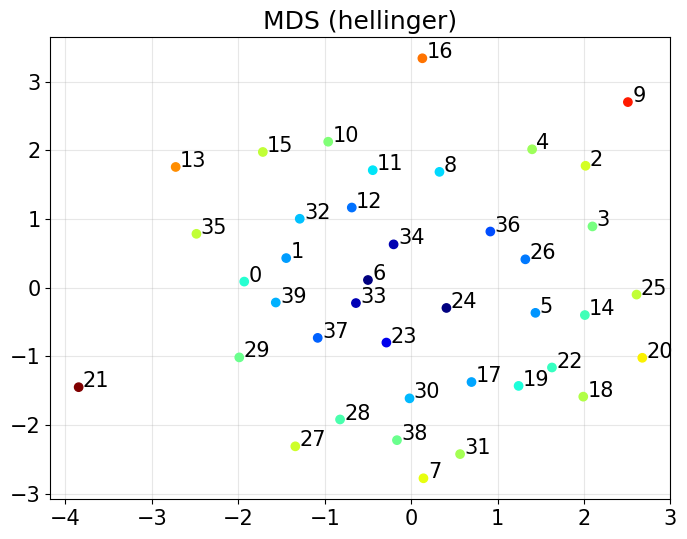

In [964]:
emb_all_shocks = FINE(merged, variable_types)

# 6) Household characteristics